# compute basic statistics on llc4320 native grid

Computation is best performed on HAL, combined with filesender to bring it back to datarmor


In [2]:
from glob import glob

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.utils as ut
import mitequinox.plot as pl

In [3]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(walltime='03:00:00')
    w = cluster.scale(jobs=10)
    client = Client(cluster)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:51800 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 100.00 GiB


In [4]:
cluster

---
# compute simple diagnostics


In [5]:
# same but over all variables and faces
#V = ["Eta", "SSU", "SSV", "SST", "SSS"]
V = ["KPPhbl", "oceTAUX", "oceTAUY"]

In [6]:
def compute_store(v, ds, diag, op):
    #i, j = ut.get_ij_dims(ds)
    diag_zarr = diag+"_"+v
    if not ut.is_diagnostic(diag_zarr):
        out, tmp_zarr = ut.custom_distribute(ds, op, 
                                             tmp_dir=ut.scratch+"tmp/", 
                                             face=1, ) # **{j: 1080}
        ut.store_diagnostic(diag_zarr, out, overwrite=True)
        print("{} {} stored".format(v, diag))
    else:
        print("{} {} already exists".format(v, diag))

In [7]:
diags = {"mean": lambda x: x.mean("time"),
         "mean_square": lambda x: (x**2).mean("time"),
        }
for v in V:
    ds = ut.load_data(v)
    for diag, op in diags.items():
        compute_store(v, ds, diag, op)

KPPhbl mean already exists
KPPhbl mean_square already exists
oceTAUX mean already exists
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/mean_square_oceTAUX.zarr
oceTAUX mean_square stored
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/mean_oceTAUY.zarr
oceTAUY mean stored
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/mean_square_oceTAUY.zarr
oceTAUY mean_square stored


In [8]:
cluster.close()

---

## derive variance and store

In [11]:
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
V = V+["KPPhbl", "oceTAUX", "oceTAUY"]

In [13]:
for v in V:
    mean = ut.load_diagnostic("mean_"+v)[v]
    mean_square = ut.load_diagnostic("mean_square_"+v)[v]
    variance = (mean_square - mean**2).rename(v)
    ut.store_diagnostic("variance_"+v, variance, overwrite=True)

data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_Eta.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_SSU.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_SSV.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_SST.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_SSS.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_KPPhbl.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_oceTAUX.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance_oceTAUY.zarr


--- 

## for each diagnostic, combine all variables into one archive

In [16]:
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
V = V+["KPPhbl", "oceTAUX", "oceTAUY"]

for d in ["mean", "mean_square", "variance"]:
    ds = xr.merge([ut.load_diagnostic(d+"_"+v)[v].rename(v) for v in V])
    ut.store_diagnostic(d, ds, overwrite=True)

data stored in /home/datawork-lops-osi/equinox/mit4320/diags/mean.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/mean_square.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/variance.zarr


---

# reload and plot

In [6]:
# load diagnostics
#V = ["SSU", "SSV",]
D = ["mean", "mean_square", "variance"]

def load_rename(d):
    ds = ut.load_diagnostic(d)
    return ds.rename({v: d+"_"+v for v in ds})

ds = xr.merge([load_rename(d) for d in D])
ds

<xarray.Dataset>
Dimensions:              (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
  * face                 (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                    (i) int64 0 1 2 3 4 5 ... 4314 4315 4316 4317 4318 4319
  * i_g                  (i_g) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
  * j                    (j) int64 0 1 2 3 4 5 ... 4314 4315 4316 4317 4318 4319
  * j_g                  (j_g) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
Data variables: (12/24)
    mean_Eta             (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_KPPhbl          (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SSS             (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SST             (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SSU             (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    mean_SSV             (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...                   ...
    variance_SSS         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    variance_SST         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    variance_SSU         (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    variance_SSV         (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    variance_oceTAUX     (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    variance_oceTAUY     (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

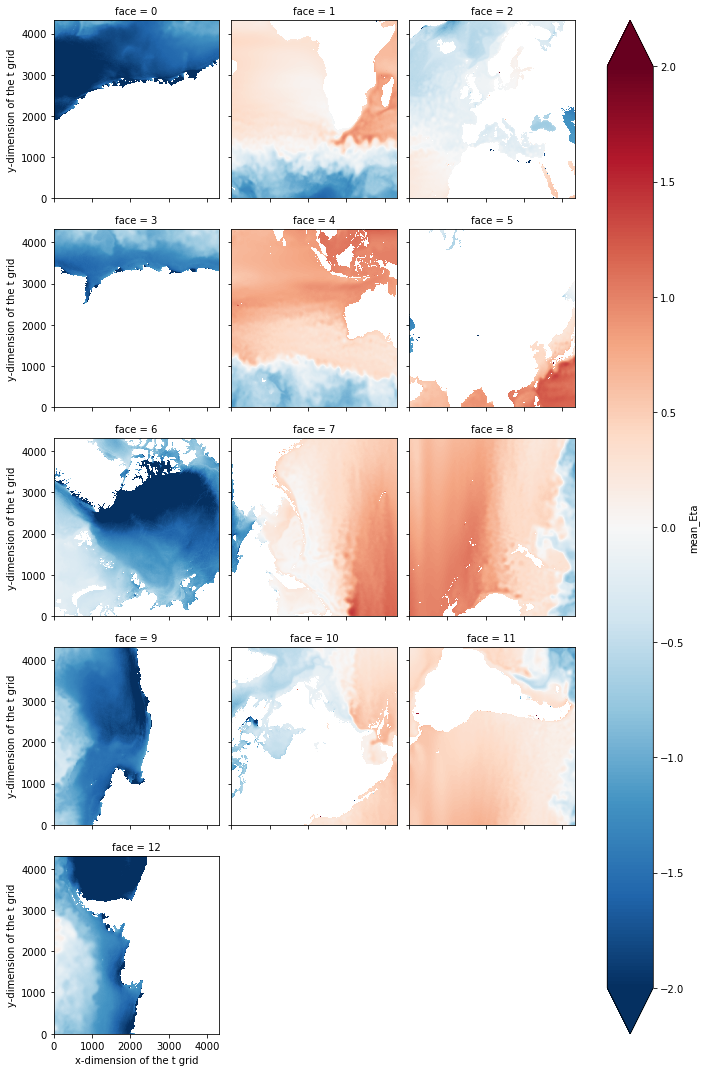

In [11]:
(ds
 .mean_Eta
 .isel(i=slice(0,None,4), j=slice(0,None,4))
 .plot(x="i", y="j", col="face", col_wrap=3,
      vmin=-2, vmax=2, cmap="RdBu_r")
)

---

In [12]:
cluster.close()